In [ ]:
import os
import re
import shutil
import string
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import losses

Download dataset:

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [ ]:
dataset

'./aclImdb_v1'

Explore directories:

In [ ]:
os.listdir(dataset_dir)

['imdbEr.txt', 'train', 'README', 'test', 'imdb.vocab']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'urls_pos.txt',
 'labeledBow.feat',
 'unsup',
 'pos',
 'urls_neg.txt',
 'neg',
 'unsupBow.feat']

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())


Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


Load data from directories using text_dataset_from_directory
---



In [ ]:
# remove the "unsup" folder to respect the folder structure
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
# Create validation and training sets from the training folder
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset="training", 
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset="validation", 
    seed=seed)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
# create test dataset 
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [ ]:
len(raw_val_ds)*32

5024

In [ ]:
raw_train_ds.class_names

['neg', 'pos']

In [ ]:
raw_train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# show one batch of reviews
for i in raw_train_ds.take(1):
  print(i)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)',
       b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose persp

In [ ]:
# show one batch of corresponding labels
for i in raw_train_ds.take(1):
  print(i[1])

tf.Tensor([1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0], shape=(32,), dtype=int32)


In [ ]:
for text, label in raw_test_ds.take(1):
  for i in range(1):
    print(text[i])
    print(label[i])

tf.Tensor(b'I can only guess that this movie was an experiment that misfired. Years earlier, it would have been moving images accompanied by music. Later, it would have been sound added to silents. Eventually it would have been Technicolor, Cinemascope or Imax. This movie must have been a misguided attempt to introduce a new element to the talking picture. During all the emotional scenes, the character stops in mid dialogue and their inner thoughts are narrated while they gaze off into the distance or appeal to the camera. This interruption is painful at it\'s very least. Imagine these top tier actors trying to look busy while the narration drones on. Painful. I have no idea who came up with this gimmick, but it was the only time I ever saw it used - and for good reason. In every scene the actors were forced to roll their eyes, wring their hands, or overact to such a degree, I actually wondered if this was really a comedy. <br /><br />The story is a hopeless soap opera that takes place

Text pre-processing
---



In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Create the pre-processing layer:

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Fit the pre-processing layer (vectorize_layer) to the training data


In [ ]:
# remove labels 
train_text = raw_train_ds.map(lambda x, y: x)

# fit the layer using the adapt method
vectorize_layer.adapt(train_text)

See result of the pre-processing layer:

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))

first_review, first_label = text_batch[0], label_batch[7]

print("Review------------", first_review)
print("Label-------------", raw_train_ds.class_names[first_label])

print("Vectorized review----------------", vectorize_text(first_review, first_label))

Review------------ tf.Tensor(b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)', shape=(), dtype=string)
Label------------- pos
Vectorized review---------------- (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4, 1233, 1021,   27,  261,  101,    4,    1, 1525,
        

In [ ]:
tf.expand_dims(first_review, -1)

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)'],
      dtype=object)>

In [ ]:
print("48 ---> ",vectorize_layer.get_vocabulary()[48])

print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

48 --->  what
Vocabulary size: 10000


In [ ]:
vectorize_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

Apply the pre-processing layer all the sets:

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Pipeline optimization:

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create the model
---



In [ ]:
from keras.regularizers import l2

In [ ]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  #layers.GlobalAveragePooling1D(),
  layers.SimpleRNN(32,return_sequences=True),
  layers.LSTM(32),
  tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(1e-3)),
  
  layers.Dense(1)])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          1568      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 170,993
Trainable params: 170,993
Non-tr

Define loss function and optimizer:

In [ ]:
from keras.callbacks import ReduceLROnPlateau

lrr= ReduceLROnPlateau(
                       monitor='val_binary_accuracy', #Metric to be measured
                       factor=.1, #Factor by which learning rate will be reduced
                       patience=2,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-6) #The minimum learning rate

from keras.callbacks import EarlyStopping

earlyStop = EarlyStopping(monitor='val_binary_accuracy',
                          patience=3)

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

Train the model:

In [ ]:
epochs = 13
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,callbacks=[lrr,earlyStop])

Epoch 1/13
625/625 [==============================] - 115s 180ms/step - loss: 0.7021 - binary_accuracy: 0.5045 - val_loss: 0.6944 - val_binary_accuracy: 0.5058 - lr: 0.0010
Epoch 2/13
625/625 [==============================] - 107s 171ms/step - loss: 0.6937 - binary_accuracy: 0.5061 - val_loss: 0.6938 - val_binary_accuracy: 0.5084 - lr: 0.0010
Epoch 3/13
625/625 [==============================] - 107s 171ms/step - loss: 0.6936 - binary_accuracy: 0.5015 - val_loss: 0.6932 - val_binary_accuracy: 0.4922 - lr: 0.0010
Epoch 4/13
625/625 [==============================] - 106s 170ms/step - loss: 0.6933 - binary_accuracy: 0.5044 - val_loss: 0.6932 - val_binary_accuracy: 0.4926 - lr: 0.0010
Epoch 5/13
625/625 [==============================] - 108s 172ms/step - loss: 0.6931 - binary_accuracy: 0.5041 - val_loss: 0.6930 - val_binary_accuracy: 0.5108 - lr: 1.0000e-04
Epoch 6/13
625/625 [==============================] - 107s 172ms/step - loss: 0.6930 - binary_accuracy: 0.5137 - val_loss: 0.6929 -

Visulalize training performance:

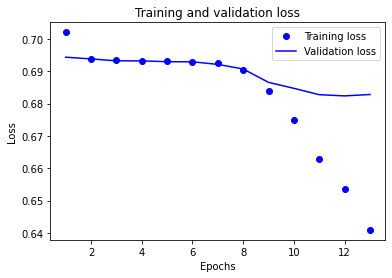

In [ ]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Evaluate the model on test data:

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 36s 45ms/step - loss: 0.6823 - binary_accuracy: 0.5875
Loss:  0.6822618246078491
Accuracy:  0.5875200033187866


## Inference on new data



Export model:

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 36s 44ms/step - loss: 0.6823 - accuracy: 0.5875
0.5875200033187866


Inference on new data:

In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 1s 668ms/step


array([[0.5986624 ],
       [0.32094583],
       [0.30727202]], dtype=float32)